# Usage Guide : pygtm
## trajectories

In [1]:
import sys
import copy
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
sys.path.insert(0, '../')
from pygtm.physical import physical_space
from pygtm.dataset import trajectory

# Load drifter trajectories
## Using the drogued drifters in GDP database in the North Atlantic ([*download* data here](https://miamiedu-my.sharepoint.com/:u:/g/personal/pxm498_miami_edu/EfaPVkKsPABJrJtKyctKrAUBpp7XzNHHrOLUhFow3pMkZw?e=MXzrcG)) and ([notebook](https://github.com/philippemiron/notebooks/blob/master/gdp.ipynb) for more info)

In [3]:
filename = 'data/gdp-north-atlantic-drogued.mat'
with h5py.File(filename, 'r') as f:
    d_id = f['id'][0]
    x = f['x'][0]  # [deg]
    y = f['y'][0]  # [deg]
    t = f['t'][0]  # [day]
del f

# drifter IDs are reused in the GDP so you make sure
# there isn't more than 10d before data points of a
# same drifter ID
I = np.where(abs(np.diff(d_id, axis=0)) > 0)[0]
I = np.insert(I, [0, len(I)], [-1, len(d_id) - 1])
max_id = np.max(d_id)

for i in range(0, len(I) - 1):
    range_i = np.arange(I[i] + 1, I[i + 1] + 1)
    t_diff = np.diff(t[range_i])

    # if there is a big gap, I changed the id and
    # treat the new segments as another drifters
    jump = np.where(t_diff > 10)[0]  # 10 days
    if len(jump) > 0:
        jump = np.insert(jump, [0, len(jump)], [-1, len(range_i) - 1])

        for j in range(0, len(jump) - 1):
            range_j = np.arange(jump[j] + 1, jump[j + 1] + 1)
            d_id[range_i[range_j]] = np.ones(len(range_j)) * (max_id + 1)  # range modification
            max_id += 1

# At any step, we can plot the original trajectoires as a reference using the function *filtering* from the trajectories module.

## For example to plot any trajectories between:
- longitude = [67°W, 60°W], 
- latitude = [40°N, 43°N]
- time = [Jan 1st - 2005, Dec. 31st - 2008] 
- complete_track=False: only *after* it reaches the region and not the full trajectories

In [4]:
def datenum_from_date(date):
    # matlab starts at year 0 and toordinal starts at year 1
    return datetime.toordinal(date) - 366

In [5]:
# filtering parameters for the trajecotires
x_range=[-67, -60]
y_range=[35, 43]
t0 = datenum_from_date(datetime(2005,1,1))
t1 = datenum_from_date(datetime(2008,12,31))
t_range=[t0, t1]

# creates segments ready to plot with add_collection()
data = trajectory(x,y,t,d_id)
segments, sid = data.filtering(x_range, y_range, t_range, complete_track=False)

/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


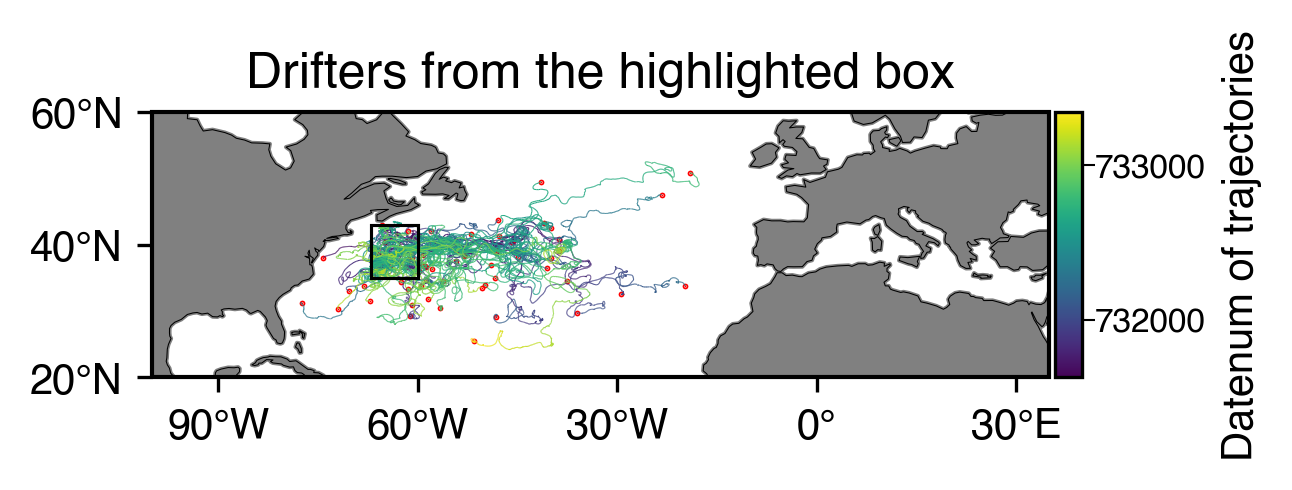

In [6]:
# plotting on a geographical map using cartopy
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

# scatter of start/finish point
# ax.scatter(x[sid[:,0]], y[sid[:,0]], s=0.15, color='b', zorder=1) # initial point of each segments
ax.scatter(x[sid[:,1]], y[sid[:,1]], s=0.15, color='r', zorder=1) # final point of each segments

cp_segments = copy.copy(segments) # just to make sure this part can run without re-filtering
ax.add_collection(cp_segments)

# plot filtering zone
p = Rectangle((x_range[0], y_range[0]), np.diff(x_range), np.diff(y_range), 
              fill=False, linewidth=0.75, zorder=2)
ax.add_patch(p)

# available function to plot the boundaries of each bin
ax.set_xlim([-100, 35])
ax.set_ylim([20, 60])
ax.set_title('Drifters from the highlighted box');

# ticks
ax.set_xticks([-90, -60, -30, 0, 30], crs=ccrs.PlateCarree())
ax.set_yticks([20, 40, 60], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
    
# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(segments, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Datenum of trajectories')